In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow import math

import pickle

# Preprocessing and Modelling

In [2]:
wvs = pd.read_csv('../data/wvs_model.csv')

In [3]:
wvs.head()

,region,authoritarianism_index,A029,A030,A032,A034,A035,A039,A040,A041,...,E069_15,F028,X045,E003,X001,X007,X028,COUNTRY_ALPHA,S002VS,S020
0,Eastern Europe,0.50,-2.0,2.0,2.0,-2.0,2.0,-2.0,-2.0,-2.0,...,-1.0,-4.0,0.0,-1,2,6,6,ALB,4,2002
1,Eastern Europe,0.50,-2.0,2.0,-2.0,-2.0,2.0,2.0,-2.0,-2.0,...,0.0,1.0,2.0,-1,1,1,3,ALB,4,2002
2,Eastern Europe,0.50,-2.0,2.0,-2.0,-2.0,2.0,2.0,-2.0,-2.0,...,0.0,-2.0,2.0,-1,1,1,4,ALB,4,2002
3,Eastern Europe,-0.50,2.0,-2.0,2.0,2.0,-2.0,2.0,-2.0,-2.0,...,-2.0,-4.0,4.0,-1,2,1,1,ALB,4,2002
4,Eastern Europe,-0.25,-2.0,2.0,2.0,-2.0,2.0,-2.0,-2.0,-2.0,...,-2.0,-4.0,1.0,-1,1,1,3,ALB,4,2002


In [4]:
wvs.shape

(406827, 57)

## Preprocessing

### Binarizing Y Variable

The next step is to turn this into a classification problem by binarizing my authoritarianism index variable.. I'll do this by treating all scores greater than 0 as **True**, while 0 or negative scores will be **False**:

In [8]:
wvs['aut_categories'] = np.where(wvs['authoritarianism_index'] > 0, 1, 0)

wvs[['aut_categories']].value_counts(normalize=True)

aut_categories
0                 0.629356
1                 0.370644
dtype: float64

In [6]:
wvs.isna().sum()

region                        0
authoritarianism_index        0
A029                        562
A030                       2805
A032                        334
A034                       4123
A035                        408
A039                       7162
A040                       2774
A041                       4102
A124_02                   22433
A124_03                   22568
A124_06                   26207
A124_07                   21342
A124_08                   22152
A124_09                   29289
A170                       3084
F063                      16001
F116                      21815
F117                      10864
F118                      29415
F120                      16823
F121                      13558
F123                      21084
X025R                      5032
X047R_WVS                 16234
A004                       7545
A005                       8050
A006                       7015
A008                       3963
A165                       6003
D054    

### Dropping Less Relevent Variables

A number of the questions above showed very little correlation to my y variable in the correlation plot that I made in my previous notebook. Better to drop some of these variables then to have to lose observations later when dropping nulls in order to include them

In [7]:
wvs = wvs.drop(columns = ['X028', 'X007', 'X001', 'E003', 'A124_08', 'region', 'A124_07', 'A124_09', 'A124_03', 'A124_02', 'A124_06', 'A165', 'S002VS'])

### Dropping Missing Variables

It looks like if I were to drop all na's at this stage, even though we lose almost 1/3 of the data, we're still left with a pretty robust data set, with about 287k observations. It also looks like removing nulls does not have much of an effect on the distribution of my y variable, with the target representing roughly 37% of the data in each case

In [9]:
nonas = wvs.dropna()

In [12]:
nonas.shape

(287493, 45)

In [10]:
nonas[['aut_categories']].value_counts(normalize=True)

aut_categories
0                 0.63044
1                 0.36956
dtype: float64

### Train Test Split

In [13]:
X = nonas.drop(columns = ['authoritarianism_index', 'COUNTRY_ALPHA', 'aut_categories'])
y = nonas['aut_categories']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.1, random_state = 1122)

### Standard Scaling

In [14]:
ss = StandardScaler()

Z_train = ss.fit_transform(X_train)
Z_test = ss.transform (X_test)

## Modelling

### Random Forest

In [141]:
rc = RandomForestClassifier(n_estimators=1800, n_jobs=12)

rc.fit(Z_train, y_train)

RandomForestClassifier(n_estimators=1800, n_jobs=12)

In [146]:
print('Train accuracy: ', rc.score(Z_train, y_train))
print('Test accuracy: ', rc.score(Z_test, y_test))

Train accuracy:  0.9999652164503001
Test accuracy:  0.7140869565217391


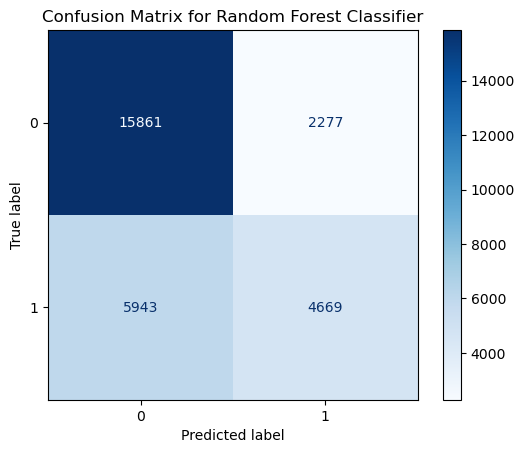

In [145]:
metrics.ConfusionMatrixDisplay.from_estimator(rc, Z_test, y_test, cmap = 'Blues')

plt.title('Confusion Matrix for Random Forest Classifier');

In [147]:
importances = pd.DataFrame({'feature_names': X.columns,
              'feature_importance': rc.feature_importances_})
importances.sort_values(by = 'feature_importance', ascending = False, inplace = True)
importances

,feature_names,feature_importance
41,S020,0.052281
8,A170,0.041690
14,F121,0.037537
39,F028,0.035727
9,F063,0.034869
13,F120,0.031207
12,F118,0.028921
40,X045,0.028909
23,D059,0.026469
18,A004,0.026321


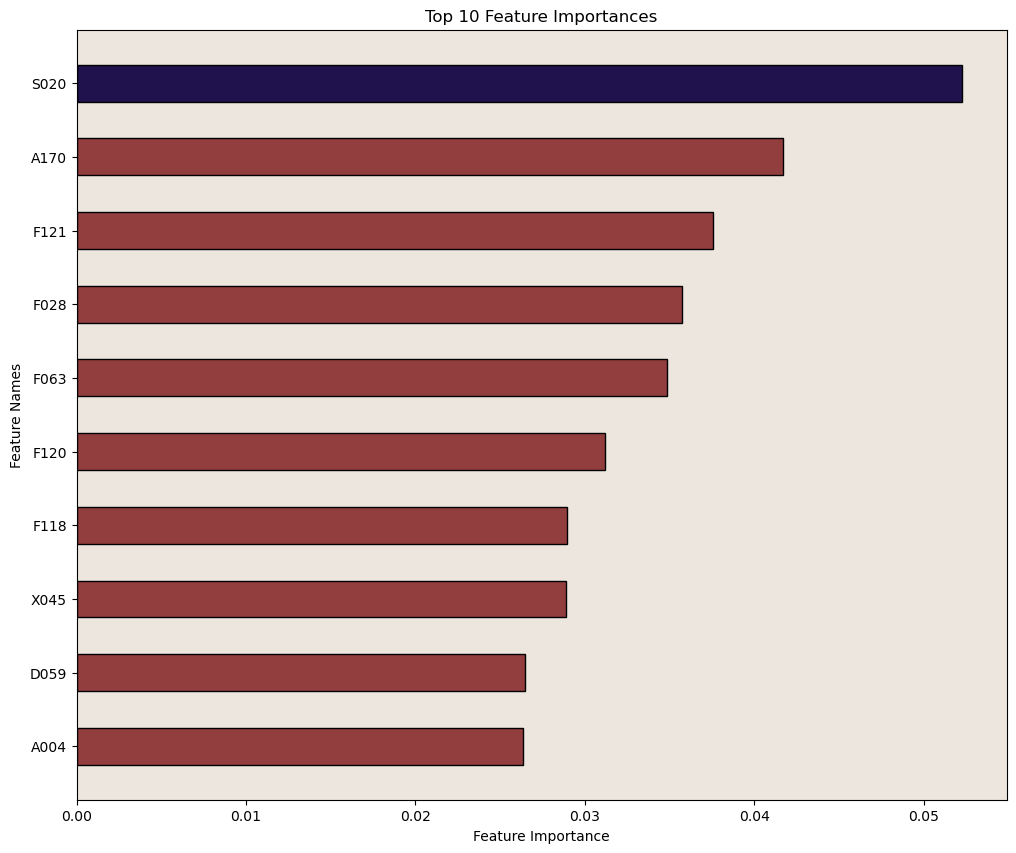

In [148]:
plt.figure(figsize=(12, 10))

imp = importances.head(10).sort_values(by='feature_importance', ascending=True)

plt.barh(imp['feature_names'],
         imp['feature_importance'],
         color=['#933e3e', '#933e3e', '#933e3e', '#933e3e', '#933e3e', '#933e3e', '#933e3e', '#933e3e', '#933e3e', '#20124d'],
         edgecolor='black',
         height=.5)

plt.gca().set_facecolor('#ede6de')

plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')

plt.title('Top 10 Feature Importances');

In [150]:
with open('../models/rf.pickle', 'wb') as f:
    pickle.dump(rc, f, protocol=pickle.HIGHEST_PROTOCOL)

### Dense Neural Network

In [55]:
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [103]:
model = Sequential()
#model.add(BatchNormalization())
model.add(Dense(2048, activation='relu', input_dim=Z_train.shape[1]))
model.add(Dropout(0.5))
#model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
#model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
           
model.compile(
    loss = 'bce',
    optimizer = 'adam',
    metrics = ['acc']
)
           
history = model.fit(
    Z_train,
    y_train,
    validation_data=(Z_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[es]
)

Epoch 1/100
4043/4043 [==============================] - 293s 72ms/step - loss: 0.6011 - acc: 0.6692 - val_loss: 0.5666 - val_acc: 0.6955
Epoch 2/100
4043/4043 [==============================] - 328s 81ms/step - loss: 0.5775 - acc: 0.6899 - val_loss: 0.5683 - val_acc: 0.6932
Epoch 3/100
4043/4043 [==============================] - 333s 82ms/step - loss: 0.5720 - acc: 0.6953 - val_loss: 0.5574 - val_acc: 0.6986
Epoch 4/100
4043/4043 [==============================] - 331s 82ms/step - loss: 0.5676 - acc: 0.6982 - val_loss: 0.5552 - val_acc: 0.7029
Epoch 5/100
4043/4043 [==============================] - 333s 82ms/step - loss: 0.5641 - acc: 0.7007 - val_loss: 0.5544 - val_acc: 0.7031
Epoch 6/100
4043/4043 [==============================] - 333s 82ms/step - loss: 0.5614 - acc: 0.7032 - val_loss: 0.5523 - val_acc: 0.7041
Epoch 7/100
4043/4043 [==============================] - 325s 80ms/step - loss: 0.5591 - acc: 0.7036 - val_loss: 0.5507 - val_acc: 0.7065
Epoch 8/100
4043/4043 [===========

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 42)               168       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 128)               5504      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)              

In [94]:
model.evaluate(Z_test, y_test)

899/899 [==============================] - 3s 4ms/step - loss: 0.5441 - acc: 0.7129


[0.5440806746482849, 0.7128695845603943]

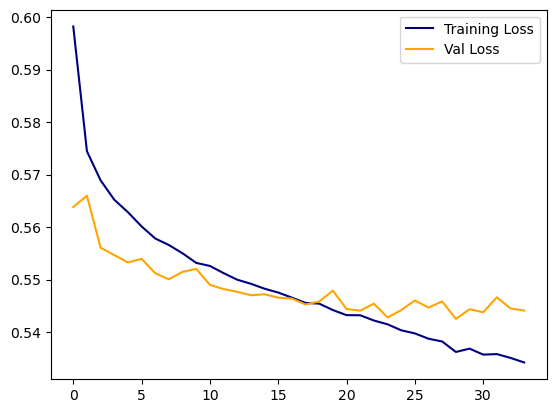

In [95]:
plt.plot(history.history['loss'], c='navy', label='Training Loss')
plt.plot(history.history['val_loss'], c='orange', label='Val Loss')
plt.legend();

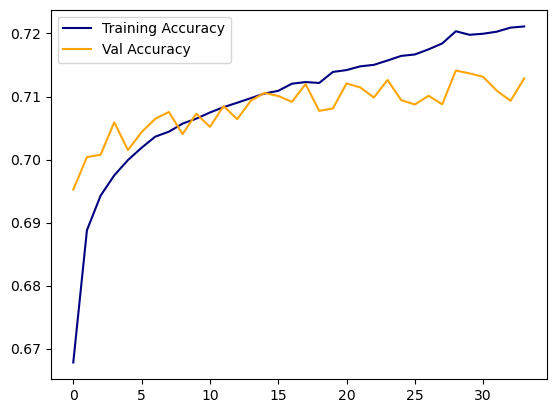

In [96]:
plt.plot(history.history['acc'], c='navy', label='Training Accuracy')
plt.plot(history.history['val_acc'], c='orange', label='Val Accuracy')
plt.legend();

In [99]:
y_train_preds = np.round(model.predict(Z_train))

8086/8086 [==============================] - 30s 4ms/step


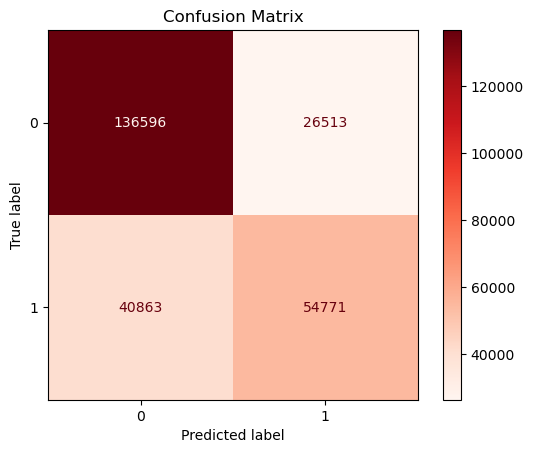

In [100]:
metrics.ConfusionMatrixDisplay.from_predictions(y_train, y_train_preds,cmap = 'Reds')
plt.title("Confusion Matrix");

In [97]:
y_preds = np.round(model.predict(Z_test))
y_preds

899/899 [==============================] - 3s 4ms/step


array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

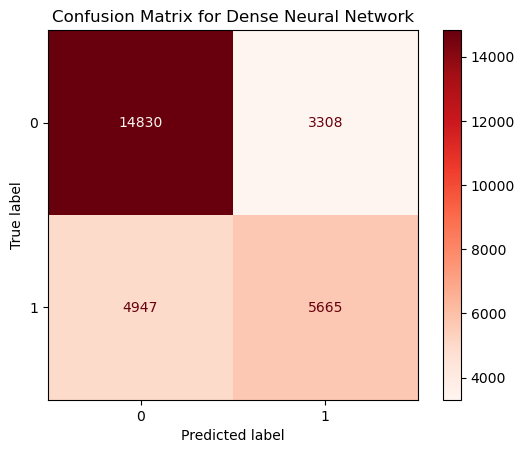

In [109]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_preds, cmap = 'Reds')
plt.title("Confusion Matrix for Dense Neural Network");

In [151]:
with open('../models/dnn.pickle', 'wb') as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-04-17 11:

In [152]:
with open('../models/dnn_history.pickle', 'wb') as f:
    pickle.dump(history, f, protocol=pickle.HIGHEST_PROTOCOL)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-04-17 12:

In [154]:
nonas.to_csv('../data/wvs_preprocessed.csv', index=False)

In [155]:
with open('../pickles/y_test.pickle', 'wb') as f:
    pickle.dump(y_test, f, protocol=pickle.HIGHEST_PROTOCOL)

In [156]:
with open('../pickles/Z_test.pickle', 'wb') as f:
    pickle.dump(Z_test, f, protocol=pickle.HIGHEST_PROTOCOL)